TEST MODEL 1

🏠 Home Goal Model Training:
[0]	validation_0-rmse:1.28204	validation_1-rmse:1.40148
[1]	validation_0-rmse:1.26754	validation_1-rmse:1.39745
[2]	validation_0-rmse:1.25398	validation_1-rmse:1.39006
[3]	validation_0-rmse:1.23746	validation_1-rmse:1.38324
[4]	validation_0-rmse:1.22314	validation_1-rmse:1.37888
[5]	validation_0-rmse:1.21003	validation_1-rmse:1.37229
[6]	validation_0-rmse:1.19575	validation_1-rmse:1.36941
[7]	validation_0-rmse:1.18381	validation_1-rmse:1.36485
[8]	validation_0-rmse:1.17246	validation_1-rmse:1.36252
[9]	validation_0-rmse:1.16207	validation_1-rmse:1.36052
[10]	validation_0-rmse:1.15219	validation_1-rmse:1.35672
[11]	validation_0-rmse:1.14163	validation_1-rmse:1.35421
[12]	validation_0-rmse:1.13017	validation_1-rmse:1.35231
[13]	validation_0-rmse:1.12030	validation_1-rmse:1.35041
[14]	validation_0-rmse:1.10944	validation_1-rmse:1.34919
[15]	validation_0-rmse:1.10051	validation_1-rmse:1.34622
[16]	validation_0-rmse:1.09024	validation_1-rmse:1.34416
[17]	validati

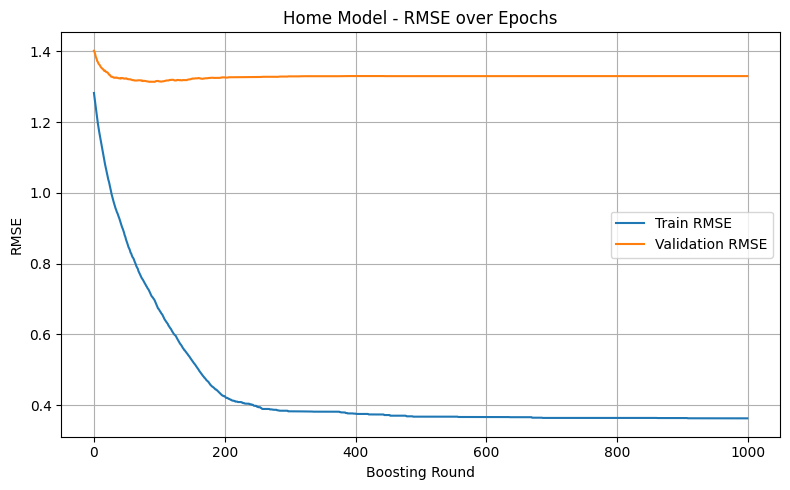

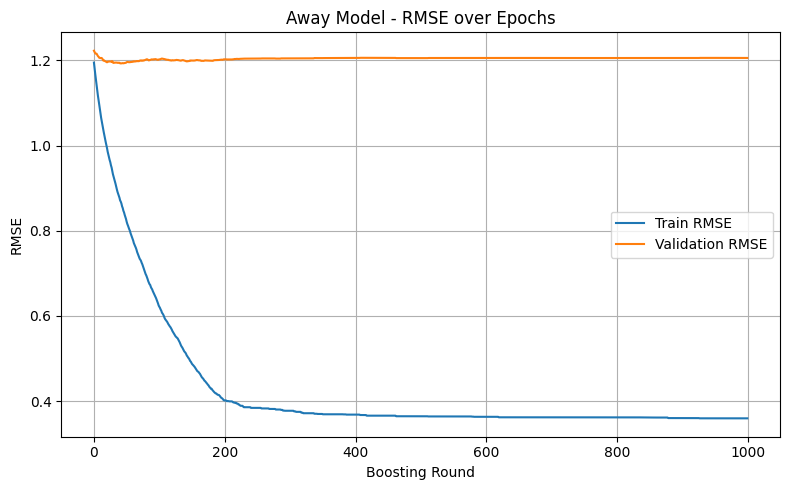

✅ 검증 성능:
[HOME_VAL] - RMSE: 1.369, MAE: 0.989, R²: 0.036
[AWAY_VAL] - RMSE: 1.237, MAE: 0.942, R²: -0.014

✅ 테스트 성능:
[HOME_TEST] - RMSE: 1.280, MAE: 0.947, R²: 0.059
[AWAY_TEST] - RMSE: 1.263, MAE: 0.938, R²: -0.044


100%|██████████| 566/566 [00:14<00:00, 39.28it/s]


📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:
→ 26.68%


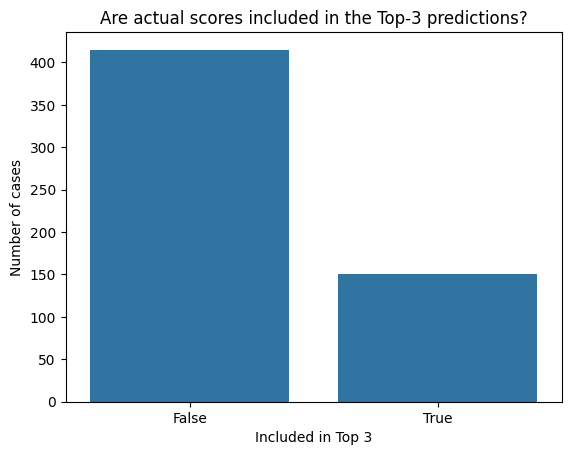


✅ Top-3 예측 결과 샘플:
  True Score Top-1 Top-2 Top-3  Hit in Top-3
0        0-2   1-2   1-1   0-2          True
1        2-0   1-1   1-0   2-1         False
2        2-2   2-0   1-0   3-0         False
3        3-0   1-1   1-0   2-1         False
4        0-2   1-0   2-0   0-0         False
5        1-2   1-1   1-2   2-1          True
6        3-0   1-0   2-0   1-1         False
7        2-0   2-1   1-1   2-0          True
8        0-0   2-0   3-0   2-1         False
9        1-1   1-1   2-1   1-2          True

📊 Feature Importance (Home Goal Model)


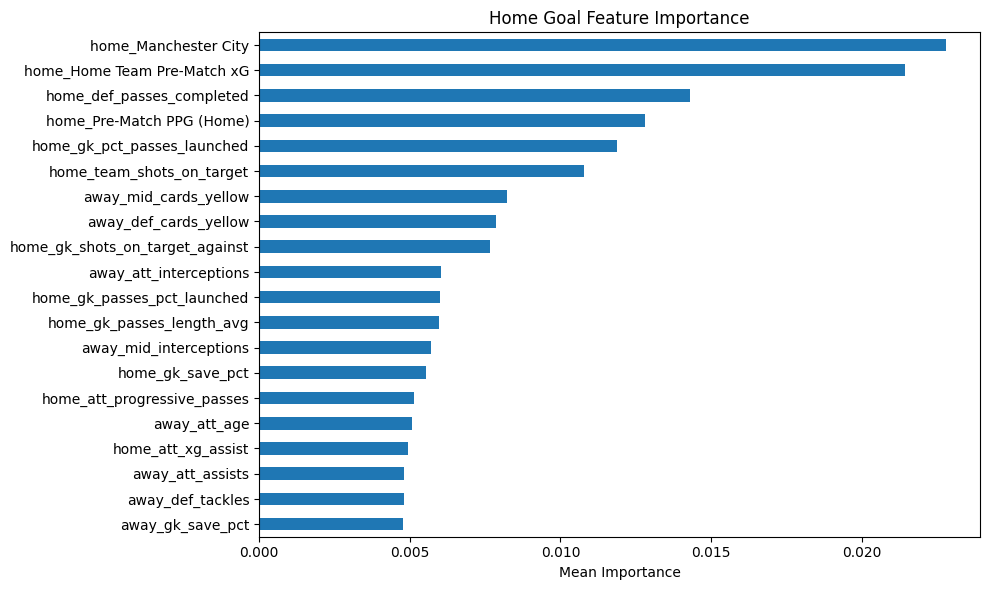


📊 Feature Importance (Away Goal Model)


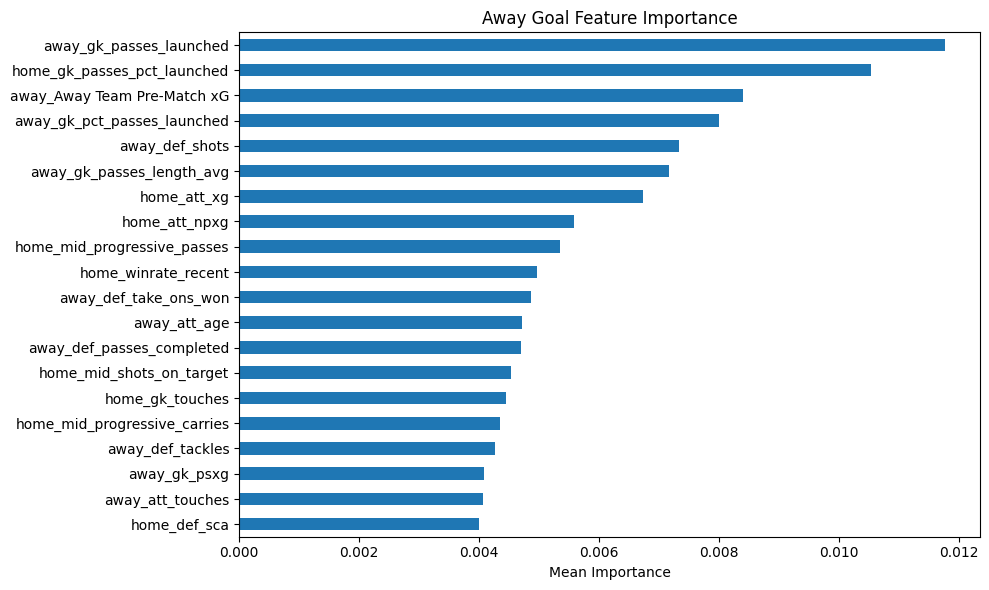

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import poisson
from tqdm import tqdm
import seaborn as sns

# 1. 데이터 로딩 및 통합
input_dir = '../data/datas/input'
csv_files = sorted([f for f in os.listdir(input_dir) if f.startswith("input_") and f.endswith(".csv")])

season_dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(input_dir, file))
    df['season'] = file.replace('final_', '').replace('.csv', '')
    season_dfs.append(df)

df = pd.concat(season_dfs, ignore_index=True)
df = df.sort_values('date')

# 2. 피처 구성 및 인코딩
target_cols = ['home_team_goal_count', 'away_team_goal_count']
meta_cols_to_drop = ['date_GMT', 'date', 'season', 'home_result', 'away_result']
X_raw = df.drop(columns=target_cols + meta_cols_to_drop, errors='ignore')
X_raw = X_raw.select_dtypes(include=['number'])

team_dummies = pd.get_dummies(df[['home_team', 'away_team']], prefix=['home', 'away'])
X = pd.concat([X_raw, team_dummies], axis=1).dropna()

y_home = df.loc[X.index, 'home_team_goal_count']
y_away = df.loc[X.index, 'away_team_goal_count']

# 3. 학습/검증/테스트 분할
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_home_train, y_home_val, y_home_test = y_home.iloc[:train_end], y_home.iloc[train_end:val_end], y_home.iloc[val_end:]
y_away_train, y_away_val, y_away_test = y_away.iloc[:train_end], y_away.iloc[train_end:val_end], y_away.iloc[val_end:]

# 4. 모델 학습 + early stopping
eval_set_home = [(X_train, y_home_train), (X_val, y_home_val)]
eval_set_away = [(X_train, y_away_train), (X_val, y_away_val)]

#4-1.
""" model_home = XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=4, eval_metric="rmse", verbosity=1)
model_away = XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=4, eval_metric="rmse", verbosity=1) """

#4-2.
""" model_home = XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=4, eval_metric="rmse", verbosity=1)
model_away = XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=4, eval_metric="rmse", verbosity=1) """

#4-3.
common_params = {
    "objective": "reg:squarederror",
    "n_estimators": 1000,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 5,
    "gamma": 1,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "verbosity": 1
}
model_home = XGBRegressor(**common_params)
model_away = XGBRegressor(**common_params)

print("🏠 Home Goal Model Training:")
model_home.fit(X_train, y_home_train, eval_set=eval_set_home, verbose=True)

print("\n🚌 Away Goal Model Training:")
model_away.fit(X_train, y_away_train, eval_set=eval_set_away, verbose=True)

evals_result_home = model_home.evals_result()
evals_result_away = model_away.evals_result()

# 4-1. 학습 곡선 시각화
def plot_learning_curve(evals_result, label="home"):
    train_metric = evals_result['validation_0']['rmse']
    val_metric = evals_result['validation_1']['rmse']
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_metric, label='Train RMSE')
    plt.plot(val_metric, label='Validation RMSE')
    plt.title(f"{label.capitalize()} Model - RMSE over Epochs")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(evals_result_home, label="home")
plot_learning_curve(evals_result_away, label="away")

# 5. 평가 함수
def evaluate(model, X, y_true, name="home"):
    y_pred = model.predict(X).round().astype(int)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name.upper()}] - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    return y_pred, rmse, mae, r2

# 6. Poisson 기반 Top-3 점수 예측
def predict_scores_with_prob(x, max_goal=5, top_k=3):
    mu_home = model_home.predict(x)[0]
    mu_away = model_away.predict(x)[0]
    result = []
    rest_prob = 0

    for h in range(max_goal + 1):
        for a in range(max_goal + 1):
            p = poisson.pmf(h, mu_home) * poisson.pmf(a, mu_away)
            result.append(((h, a), p))

    for h in range(max_goal + 1):
        rest_prob += poisson.pmf(h, mu_home) * (1 - poisson.cdf(max_goal, mu_away))
        rest_prob += (1 - poisson.cdf(max_goal, mu_home)) * poisson.pmf(h, mu_away)
    rest_prob -= (1 - poisson.cdf(max_goal, mu_home)) * (1 - poisson.cdf(max_goal, mu_away))

    result.append((("5+", "5+"), rest_prob))
    return {
        "home_expected_goals": mu_home,
        "away_expected_goals": mu_away,
        "top_predictions": sorted(result, key=lambda x: x[1], reverse=True)[:top_k]
    }

# 7. 검증/테스트 평가
print("✅ 검증 성능:")
y_home_val_pred, _, _, _ = evaluate(model_home, X_val, y_home_val, "home_val")
y_away_val_pred, _, _, _ = evaluate(model_away, X_val, y_away_val, "away_val")

print("\n✅ 테스트 성능:")
y_home_test_pred, _, _, _ = evaluate(model_home, X_test, y_home_test, "home_test")
y_away_test_pred, _, _, _ = evaluate(model_away, X_test, y_away_test, "away_test")

# 8. Top-3 정답 포함 여부 계산
results = []
for i in tqdm(range(len(X_test))):
    x = X_test.iloc[[i]]
    true_home = y_home_test.iloc[i]
    true_away = y_away_test.iloc[i]
    pred = predict_scores_with_prob(x, top_k=3)
    top_scores = [f"{h}-{a}" for (h, a), _ in pred["top_predictions"]]
    true_score = f"{true_home}-{true_away}"
    hit = true_score in top_scores

    results.append({
        "True Score": true_score,
        "Top-1": top_scores[0],
        "Top-2": top_scores[1] if len(top_scores) > 1 else "-",
        "Top-3": top_scores[2] if len(top_scores) > 2 else "-",
        "Hit in Top-3": hit
    })

df_results = pd.DataFrame(results)
print("\n📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:")
print(f"→ {df_results['Hit in Top-3'].mean():.2%}")

# 9. 시각화
sns.countplot(data=df_results, x="Hit in Top-3")
plt.title("Are actual scores included in the Top-3 predictions?")
plt.xlabel("Included in Top 3")
plt.ylabel("Number of cases")
plt.show()

print("\n✅ Top-3 예측 결과 샘플:")
print(df_results.head(10))

# 10. Feature 중요도 시각화
def plot_feature_importance(model, X_val, y_val, title="Permutation Importance", top_n=20):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
    importance_series = pd.Series(result.importances_mean, index=X_val.columns)
    top_features = importance_series.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh')
    plt.title(title)
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()

print("\n📊 Feature Importance (Home Goal Model)")
plot_feature_importance(model_home, X_val, y_home_val, title="Home Goal Feature Importance", top_n=20)

print("\n📊 Feature Importance (Away Goal Model)")
plot_feature_importance(model_away, X_val, y_away_val, title="Away Goal Feature Importance", top_n=20)


TEST MODEL 2

🏠 Home Goal Model Training:
[0]	validation_0-rmse:1.24238	validation_1-rmse:1.31021
[1]	validation_0-rmse:1.19210	validation_1-rmse:1.26640
[2]	validation_0-rmse:1.14348	validation_1-rmse:1.22548
[3]	validation_0-rmse:1.09919	validation_1-rmse:1.18733
[4]	validation_0-rmse:1.05715	validation_1-rmse:1.14924
[5]	validation_0-rmse:1.01698	validation_1-rmse:1.11469
[6]	validation_0-rmse:0.97761	validation_1-rmse:1.07775
[7]	validation_0-rmse:0.94094	validation_1-rmse:1.04398
[8]	validation_0-rmse:0.90629	validation_1-rmse:1.01400
[9]	validation_0-rmse:0.87277	validation_1-rmse:0.98591
[10]	validation_0-rmse:0.83955	validation_1-rmse:0.95772
[11]	validation_0-rmse:0.81260	validation_1-rmse:0.93383
[12]	validation_0-rmse:0.78499	validation_1-rmse:0.90864
[13]	validation_0-rmse:0.75647	validation_1-rmse:0.88382
[14]	validation_0-rmse:0.73002	validation_1-rmse:0.86086
[15]	validation_0-rmse:0.70549	validation_1-rmse:0.84084
[16]	validation_0-rmse:0.68126	validation_1-rmse:0.82093
[17]	validati

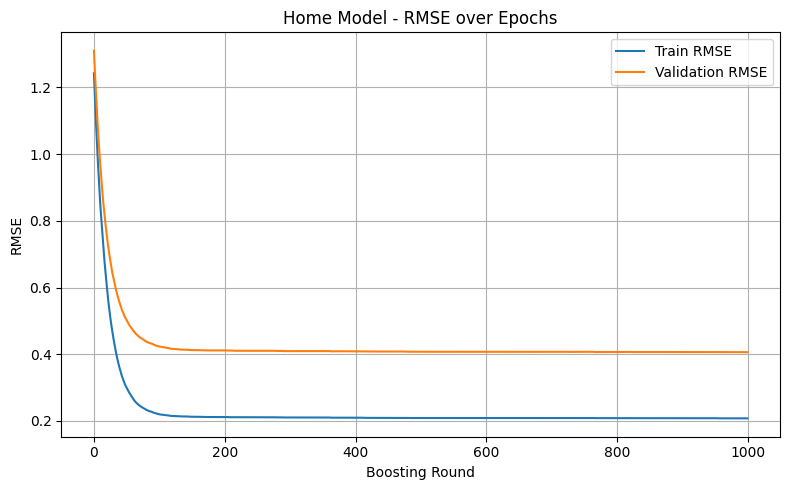

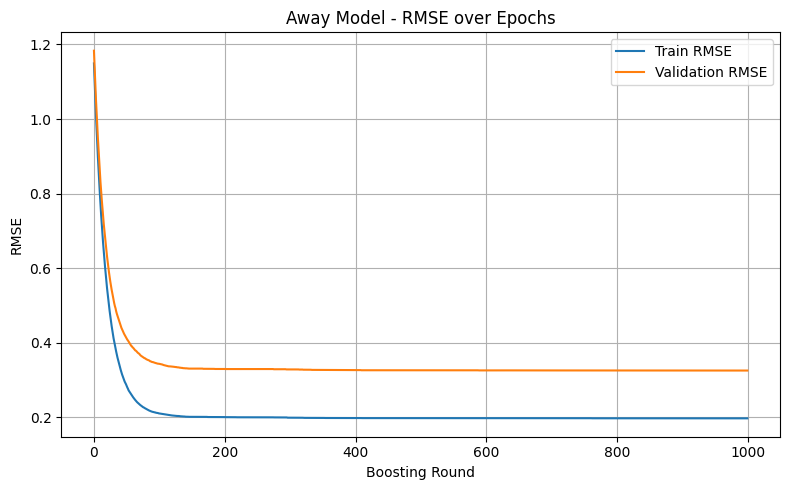

✅ 검증 성능:
[HOME_VAL] - RMSE: 0.443, MAE: 0.173, R²: 0.892
[AWAY_VAL] - RMSE: 0.349, MAE: 0.118, R²: 0.919

✅ 테스트 성능:
[HOME_TEST] - RMSE: 0.362, MAE: 0.124, R²: 0.923
[AWAY_TEST] - RMSE: 0.383, MAE: 0.124, R²: 0.899


100%|██████████| 510/510 [00:14<00:00, 36.38it/s]


📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:
→ 72.55%


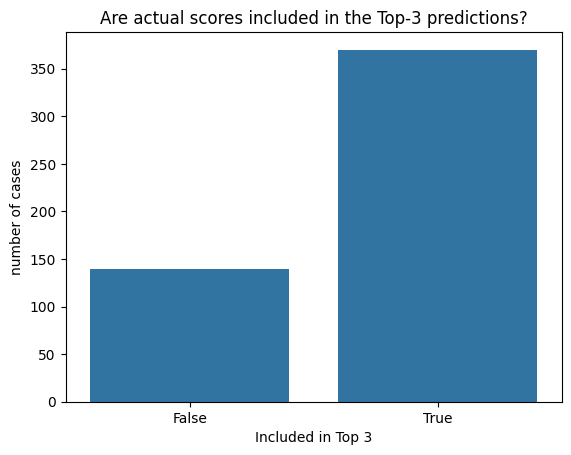


✅ Top-3 예측 결과 샘플:
  True Score  Top-1 Top-2 Top-3  Hit in Top-3
0        2-1    1-0   2-0   1-1         False
1        5-0  5+-5+   4-0   5-0          True
2        0-2    0-1   0-2   0-3          True
3        0-2    0-1   0-0   0-2          True
4        1-0    1-0   0-0   2-0          True
5        2-1    2-1   1-1   2-0          True
6        3-0    2-0   1-0   3-0          True
7        1-2    1-1   0-1   1-2          True
8        1-2    0-1   1-1   0-2         False
9        0-3    0-2   0-3   0-1          True

📊 Feature Importance (Home Goal Model)


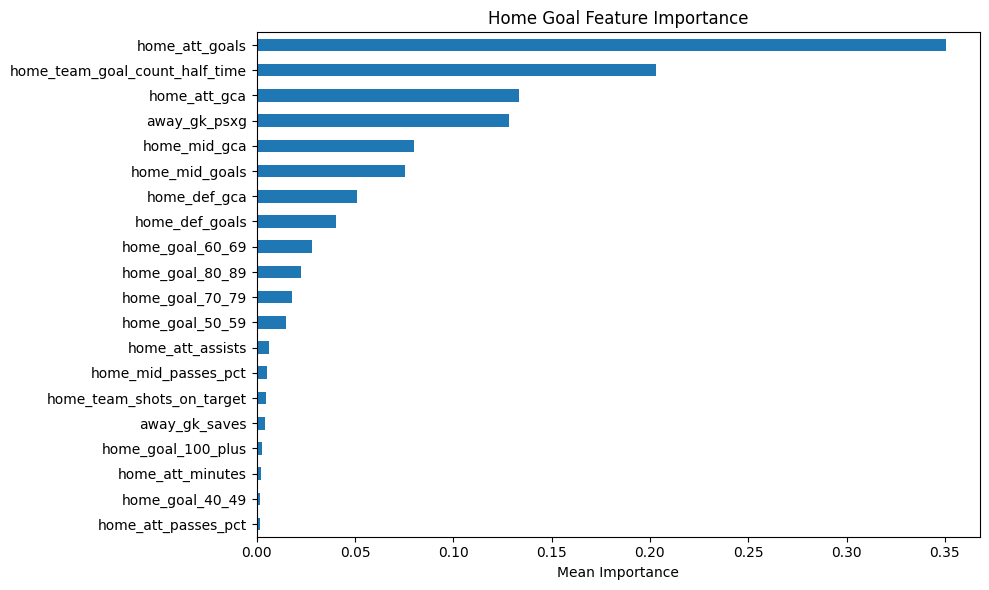


📊 Feature Importance (Away Goal Model)


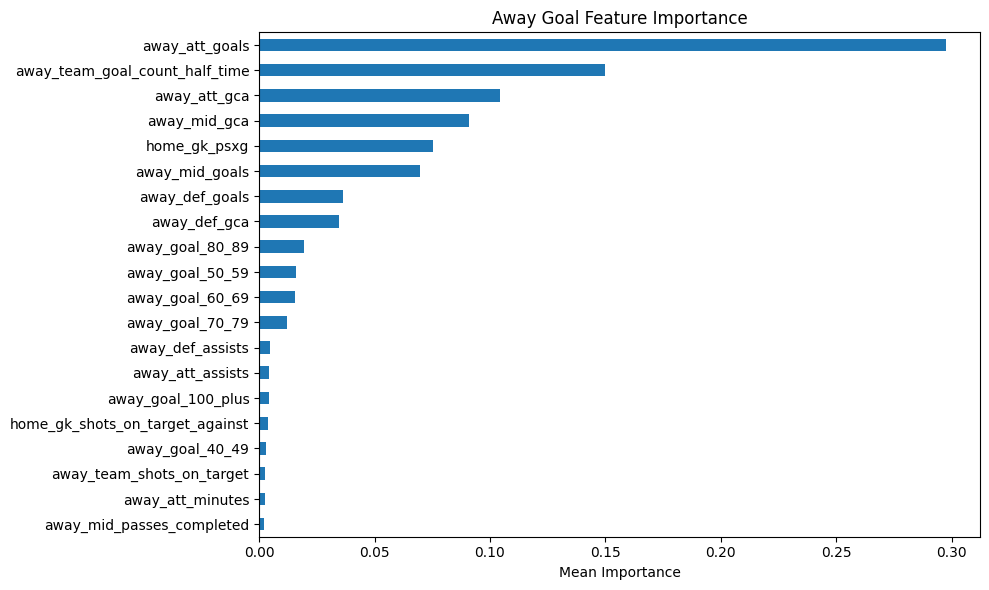

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import poisson
from tqdm import tqdm
import seaborn as sns

#데이터 로딩 및 통합
input_dir = '../../data/datas/2/final'
csv_files = sorted([f for f in os.listdir(input_dir) if f.startswith("final_") and f.endswith(".csv")])

season_dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(input_dir, file))
    df['season'] = file.replace('final_', '').replace('.csv', '')
    season_dfs.append(df)

df = pd.concat(season_dfs, ignore_index=True)
df['date'] = pd.to_datetime(df['date_GMT'], errors='coerce')
df = df.sort_values('date')

#피처 구성 및 인코딩
target_cols = ['home_team_goal_count', 'away_team_goal_count']
meta_cols_to_drop = ['date_GMT', 'date', 'season', 'home_result', 'away_result', 'home_gk_save_pct', 'away_gk_save_pct']
X_raw = df.drop(columns=target_cols + meta_cols_to_drop, errors='ignore')
X_raw = X_raw.select_dtypes(include=['number'])  # 숫자형만 사용

team_dummies = pd.get_dummies(df[['home_team_name', 'away_team_name']], prefix=['home', 'away'])
X = pd.concat([X_raw, team_dummies], axis=1).dropna()

y_home = df.loc[X.index, 'home_team_goal_count']
y_away = df.loc[X.index, 'away_team_goal_count']

#학습/검증/테스트 분할
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_home_train, y_home_val, y_home_test = y_home.iloc[:train_end], y_home.iloc[train_end:val_end], y_home.iloc[val_end:]
y_away_train, y_away_val, y_away_test = y_away.iloc[:train_end], y_away.iloc[train_end:val_end], y_away.iloc[val_end:]

eval_set_home = [(X_train, y_home_train), (X_val, y_home_val)]
eval_set_away = [(X_train, y_away_train), (X_val, y_away_val)]

#모델 학습

common_params = {
    "objective": "reg:squarederror",
    "n_estimators": 1000,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 5,
    "gamma": 1,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "verbosity": 1
}


model_home = XGBRegressor(**common_params)
model_away = XGBRegressor(**common_params)

print("🏠 Home Goal Model Training:")
model_home.fit(X_train, y_home_train, eval_set=eval_set_home, verbose=True)
print("\n🚌 Away Goal Model Training:")
model_away.fit(X_train, y_away_train, eval_set=eval_set_away, verbose=True)

evals_result_home = model_home.evals_result()
evals_result_away = model_away.evals_result()

def plot_learning_curve(evals_result, label="home"):
    train_metric = evals_result['validation_0']['rmse']
    val_metric = evals_result['validation_1']['rmse']
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_metric, label='Train RMSE')
    plt.plot(val_metric, label='Validation RMSE')
    plt.title(f"{label.capitalize()} Model - RMSE over Epochs")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(evals_result_home, label="home")
plot_learning_curve(evals_result_away, label="away")

#평가 함수
def evaluate(model, X, y_true, name="home"):
    y_pred = model.predict(X).round().astype(int)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name.upper()}] - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    return y_pred, rmse, mae, r2

#Poisson 기반 Top-3 점수 예측
def predict_scores_with_prob(x, max_goal=5, top_k=3):
    mu_home = model_home.predict(x)[0]
    mu_away = model_away.predict(x)[0]
    result = []
    
    home_win_prob = 0
    draw_prob = 0
    away_win_prob = 0
    rest_prob = 0

    for h in range(max_goal + 1):
        for a in range(max_goal + 1):
            p = poisson.pmf(h, mu_home) * poisson.pmf(a, mu_away)
            result.append(((h, a), p))
            if h > a:
                home_win_prob += p
            elif h == a:
                draw_prob += p
            else:
                away_win_prob += p

    # "5+ goals" 예외 처리 확률 계산
    for h in range(max_goal + 1):
        rest_prob += poisson.pmf(h, mu_home) * (1 - poisson.cdf(max_goal, mu_away))
        rest_prob += (1 - poisson.cdf(max_goal, mu_home)) * poisson.pmf(h, mu_away)
    rest_prob -= (1 - poisson.cdf(max_goal, mu_home)) * (1 - poisson.cdf(max_goal, mu_away))

    result.append((("5+", "5+"), rest_prob))

    # 정규화된 승/무/패 확률
    total = home_win_prob + draw_prob + away_win_prob
    home_win_prob /= total
    draw_prob /= total
    away_win_prob /= total

    return {
        "home_expected_goals": mu_home,
        "away_expected_goals": mu_away,
        "top_predictions": sorted(result, key=lambda x: x[1], reverse=True)[:top_k],
        "home_win_prob": home_win_prob,
        "draw_prob": draw_prob,
        "away_win_prob": away_win_prob
    }

# 평가 결과 출력
print("✅ 검증 성능:")
y_home_val_pred, _, _, _ = evaluate(model_home, X_val, y_home_val, "home_val")
y_away_val_pred, _, _, _ = evaluate(model_away, X_val, y_away_val, "away_val")

print("\n✅ 테스트 성능:")
y_home_test_pred, _, _, _ = evaluate(model_home, X_test, y_home_test, "home_test")
y_away_test_pred, _, _, _ = evaluate(model_away, X_test, y_away_test, "away_test")
    
# Poisson Top-3 결과 확인
results = []
for i in tqdm(range(len(X_test))):
    x = X_test.iloc[[i]]
    true_home = y_home_test.iloc[i]
    true_away = y_away_test.iloc[i]
    pred = predict_scores_with_prob(x, top_k=3)
    top_scores = [f"{h}-{a}" for (h, a), _ in pred["top_predictions"]]
    true_score = f"{true_home}-{true_away}"
    hit = true_score in top_scores

    results.append({
        "True Score": true_score,
        "Top-1": top_scores[0],
        "Top-2": top_scores[1] if len(top_scores) > 1 else "-",
        "Top-3": top_scores[2] if len(top_scores) > 2 else "-",
        "Hit in Top-3": hit
    })

df_results = pd.DataFrame(results)
print("\n📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:")
print(f"→ {df_results['Hit in Top-3'].mean():.2%}")

# 시각화
sns.countplot(data=df_results, x="Hit in Top-3")
plt.title("Are actual scores included in the Top-3 predictions?")
plt.xlabel("Included in Top 3")
plt.ylabel("number of cases")
plt.show()

print("\n✅ Top-3 예측 결과 샘플:")
print(df_results.head(10))

# Feature 중요도 시각화
def plot_feature_importance(model, X_val, y_val, title="Permutation Importance", top_n=20):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
    importance_series = pd.Series(result.importances_mean, index=X_val.columns)
    top_features = importance_series.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh')
    plt.title(title)
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()


print("\n📊 Feature Importance (Home Goal Model)")
plot_feature_importance(model_home, X_val, y_home_val, title="Home Goal Feature Importance", top_n=20)

print("\n📊 Feature Importance (Away Goal Model)")
plot_feature_importance(model_away, X_val, y_away_val, title="Away Goal Feature Importance", top_n=20)




Final Model

🏠 Home Goal Model Training:
[0]	validation_0-rmse:1.24233	validation_1-rmse:1.30898
[1]	validation_0-rmse:1.19138	validation_1-rmse:1.26301
[2]	validation_0-rmse:1.14291	validation_1-rmse:1.22132
[3]	validation_0-rmse:1.09780	validation_1-rmse:1.18173
[4]	validation_0-rmse:1.05485	validation_1-rmse:1.14379
[5]	validation_0-rmse:1.01390	validation_1-rmse:1.10764
[6]	validation_0-rmse:0.97387	validation_1-rmse:1.07091
[7]	validation_0-rmse:0.93575	validation_1-rmse:1.03796
[8]	validation_0-rmse:0.90120	validation_1-rmse:1.00735
[9]	validation_0-rmse:0.86749	validation_1-rmse:0.97901
[10]	validation_0-rmse:0.83489	validation_1-rmse:0.95184
[11]	validation_0-rmse:0.80678	validation_1-rmse:0.92650
[12]	validation_0-rmse:0.77849	validation_1-rmse:0.90202
[13]	validation_0-rmse:0.75069	validation_1-rmse:0.87947
[14]	validation_0-rmse:0.72404	validation_1-rmse:0.85654
[15]	validation_0-rmse:0.69946	validation_1-rmse:0.83577
[16]	validation_0-rmse:0.67507	validation_1-rmse:0.81576
[17]	validati

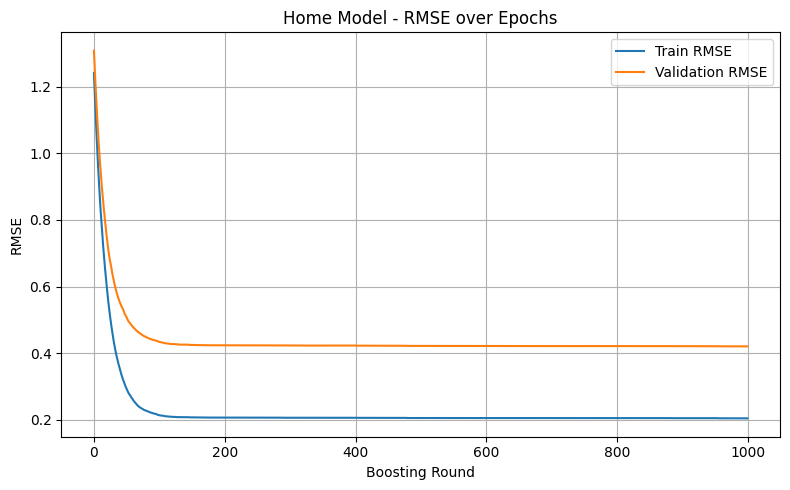

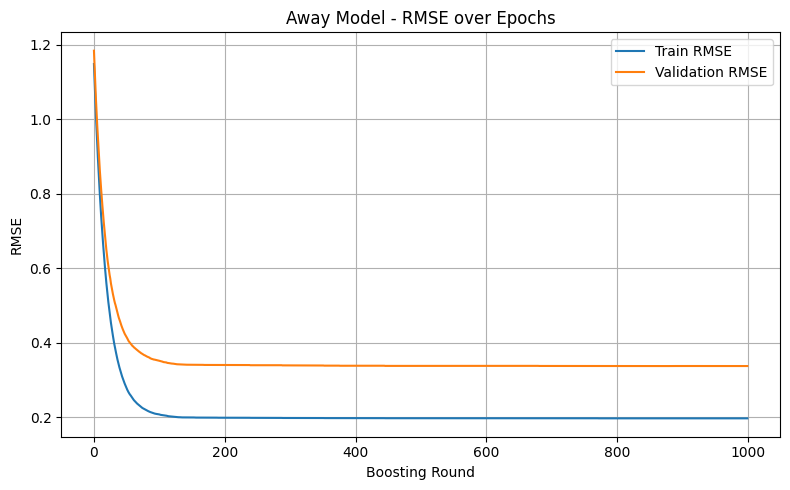

✅ 검증 성능:
[HOME_VAL] - RMSE: 0.456, MAE: 0.176, R²: 0.886
[AWAY_VAL] - RMSE: 0.354, MAE: 0.110, R²: 0.917

✅ 테스트 성능:
[HOME_TEST] - RMSE: 0.368, MAE: 0.127, R²: 0.921
[AWAY_TEST] - RMSE: 0.383, MAE: 0.131, R²: 0.899


100%|██████████| 510/510 [00:13<00:00, 38.62it/s]


📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:
→ 69.80%


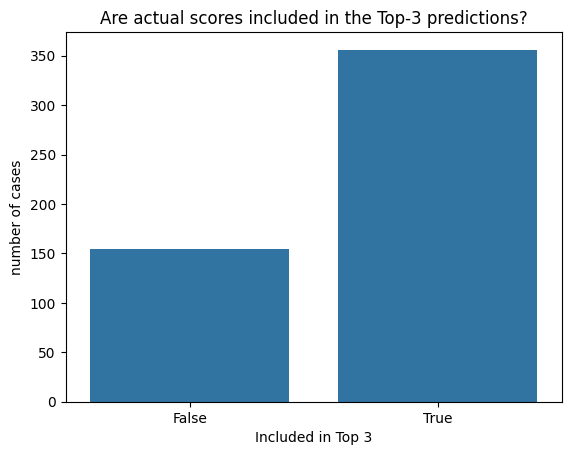


✅ Top-3 예측 결과 샘플:
  True Score Top-1 Top-2 Top-3  Hit in Top-3
0        2-1   2-0   2-1   1-0          True
1        5-0   2-0   3-0   1-0         False
2        0-2   0-1   0-2   0-3          True
3        0-2   0-1   0-0   0-2          True
4        1-0   1-0   0-0   2-0          True
5        2-1   2-1   1-1   2-0          True
6        3-0   2-0   1-0   3-0          True
7        1-2   1-1   0-1   1-2          True
8        1-2   1-1   0-1   1-2          True
9        0-3   0-2   0-3   0-1          True

📊 Feature Importance (Home Goal Model)


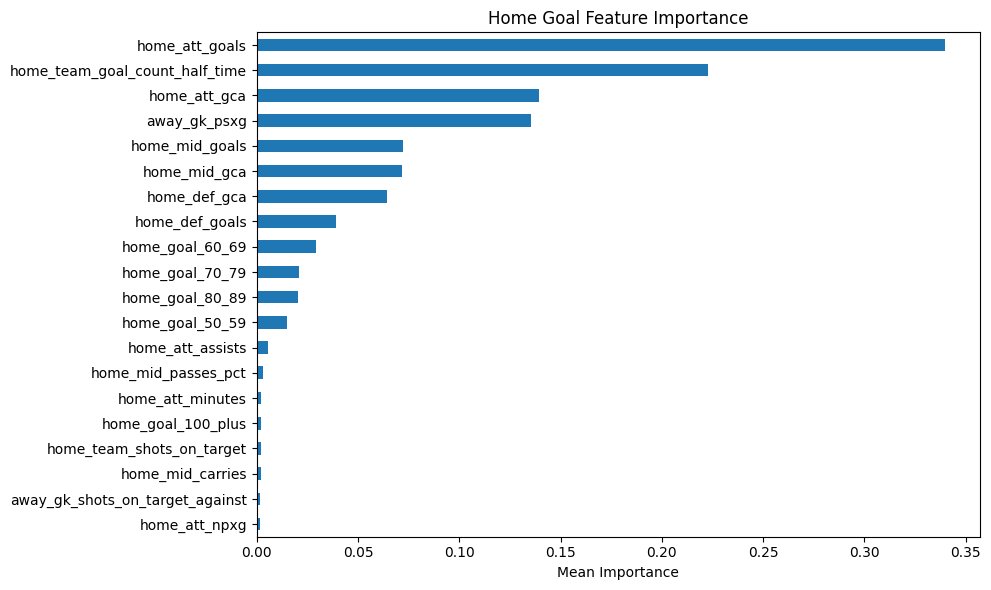


📊 Feature Importance (Away Goal Model)


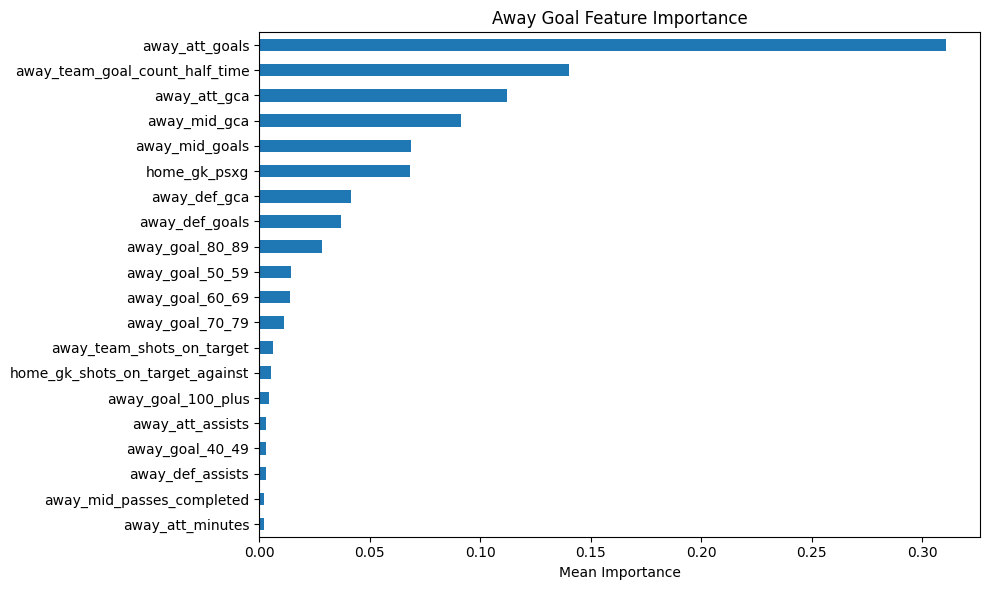

In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import poisson
from tqdm import tqdm
import seaborn as sns

#데이터 로딩 및 통합
input_dir = '../../data/datas/2/final'
csv_files = sorted([f for f in os.listdir(input_dir) if f.startswith("final_") and f.endswith(".csv")])

season_dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(input_dir, file))
    df['season'] = file.replace('final_', '').replace('.csv', '')
    season_dfs.append(df)

df = pd.concat(season_dfs, ignore_index=True)
df['date'] = pd.to_datetime(df['date_GMT'], errors='coerce')
df = df.sort_values('date')

#피처 구성 및 인코딩
target_cols = ['home_team_goal_count', 'away_team_goal_count']
meta_cols_to_drop = ['date_GMT', 'date', 'season', 'home_result', 'away_result', 'home_gk_save_pct', 'away_gk_save_pct']
X_raw = df.drop(columns=target_cols + meta_cols_to_drop, errors='ignore')
X_raw = X_raw.select_dtypes(include=['number'])  # 숫자형만 사용

team_dummies = pd.get_dummies(df[['home_team_name', 'away_team_name']], prefix=['home', 'away'])
X = pd.concat([X_raw, team_dummies], axis=1).dropna()

y_home = df.loc[X.index, 'home_team_goal_count']
y_away = df.loc[X.index, 'away_team_goal_count']

#학습/검증/테스트 분할
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_home_train, y_home_val, y_home_test = y_home.iloc[:train_end], y_home.iloc[train_end:val_end], y_home.iloc[val_end:]
y_away_train, y_away_val, y_away_test = y_away.iloc[:train_end], y_away.iloc[train_end:val_end], y_away.iloc[val_end:]

eval_set_home = [(X_train, y_home_train), (X_val, y_home_val)]
eval_set_away = [(X_train, y_away_train), (X_val, y_away_val)]

#모델 학습
common_params1 = {
    "objective": "reg:squarederror",
    "n_estimators": 1000,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "min_child_weight": 3,
    "gamma": 1,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "verbosity": 1
}

model_home = XGBRegressor(**common_params1)
model_away = XGBRegressor(**common_params1)

print("🏠 Home Goal Model Training:")
model_home.fit(X_train, y_home_train, eval_set=eval_set_home, verbose=True)
print("\n🚌 Away Goal Model Training:")
model_away.fit(X_train, y_away_train, eval_set=eval_set_away, verbose=True)

evals_result_home = model_home.evals_result()
evals_result_away = model_away.evals_result()

def plot_learning_curve(evals_result, label="home"):
    train_metric = evals_result['validation_0']['rmse']
    val_metric = evals_result['validation_1']['rmse']
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_metric, label='Train RMSE')
    plt.plot(val_metric, label='Validation RMSE')
    plt.title(f"{label.capitalize()} Model - RMSE over Epochs")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(evals_result_home, label="home")
plot_learning_curve(evals_result_away, label="away")

#평가 함수
def evaluate(model, X, y_true, name="home"):
    y_pred = model.predict(X).round().astype(int)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name.upper()}] - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    return y_pred, rmse, mae, r2

def predict_scores_with_prob(x, max_goal=3, top_k=3):
    mu_home = model_home.predict(x)[0]
    mu_away = model_away.predict(x)[0]

    # 기대득점(mu) 제한
    mu_home = min(mu_home, max_goal)
    mu_away = min(mu_away, max_goal)

    result = []
    home_win_prob = 0
    draw_prob = 0
    away_win_prob = 0
    rest_prob = 0

    # 5+ 점수 예측을 방지하기 위해 max_goal을 3으로 설정
    for h in range(max_goal + 1):
        for a in range(max_goal + 1):
            p = poisson.pmf(h, mu_home) * poisson.pmf(a, mu_away)
            result.append(((h, a), p))
            if h > a:
                home_win_prob += p
            elif h == a:
                draw_prob += p
            else:
                away_win_prob += p

    # 5+ 득점 예외 처리 확률 계산
    for h in range(max_goal + 1):
        rest_prob += poisson.pmf(h, mu_home) * (1 - poisson.cdf(max_goal, mu_away))
        rest_prob += (1 - poisson.cdf(max_goal, mu_home)) * poisson.pmf(h, mu_away)
    rest_prob -= (1 - poisson.cdf(max_goal, mu_home)) * (1 - poisson.cdf(max_goal, mu_away))

    # 5+를 제외하는 방식으로 확률을 0으로 설정
    result.append((("5+", "5+"), 0))

    # 정규화된 승/무/패 확률
    total = home_win_prob + draw_prob + away_win_prob
    home_win_prob /= total
    draw_prob /= total
    away_win_prob /= total

    return {
        "home_expected_goals": mu_home,
        "away_expected_goals": mu_away,
        "top_predictions": sorted(result, key=lambda x: x[1], reverse=True)[:top_k],
        "home_win_prob": home_win_prob,
        "draw_prob": draw_prob,
        "away_win_prob": away_win_prob
    }

# 평가 결과 출력
print("✅ 검증 성능:")
y_home_val_pred, _, _, _ = evaluate(model_home, X_val, y_home_val, "home_val")
y_away_val_pred, _, _, _ = evaluate(model_away, X_val, y_away_val, "away_val")

print("\n✅ 테스트 성능:")
y_home_test_pred, _, _, _ = evaluate(model_home, X_test, y_home_test, "home_test")
y_away_test_pred, _, _, _ = evaluate(model_away, X_test, y_away_test, "away_test")
    
# Poisson Top-3 결과 확인
results = []
for i in tqdm(range(len(X_test))):
    x = X_test.iloc[[i]]
    true_home = y_home_test.iloc[i]
    true_away = y_away_test.iloc[i]
    pred = predict_scores_with_prob(x, top_k=3)
    top_scores = [f"{h}-{a}" for (h, a), _ in pred["top_predictions"]]
    true_score = f"{true_home}-{true_away}"
    hit = true_score in top_scores

    results.append({
        "True Score": true_score,
        "Top-1": top_scores[0],
        "Top-2": top_scores[1] if len(top_scores) > 1 else "-",
        "Top-3": top_scores[2] if len(top_scores) > 2 else "-",
        "Hit in Top-3": hit
    })

df_results = pd.DataFrame(results)
print("\n📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:")
print(f"→ {df_results['Hit in Top-3'].mean():.2%}")

# 시각화
sns.countplot(data=df_results, x="Hit in Top-3")
plt.title("Are actual scores included in the Top-3 predictions?")
plt.xlabel("Included in Top 3")
plt.ylabel("number of cases")
plt.show()

print("\n✅ Top-3 예측 결과 샘플:")
print(df_results.head(10))

# Feature 중요도 시각화
def plot_feature_importance(model, X_val, y_val, title="Permutation Importance", top_n=20):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
    importance_series = pd.Series(result.importances_mean, index=X_val.columns)
    top_features = importance_series.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh')
    plt.title(title)
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()


print("\n📊 Feature Importance (Home Goal Model)")
plot_feature_importance(model_home, X_val, y_home_val, title="Home Goal Feature Importance", top_n=20)

print("\n📊 Feature Importance (Away Goal Model)")
plot_feature_importance(model_away, X_val, y_away_val, title="Away Goal Feature Importance", top_n=20)




승/무/패 예측 모델

▶ 'predictions.csv' 파일로 저장했습니다: (606, 10)


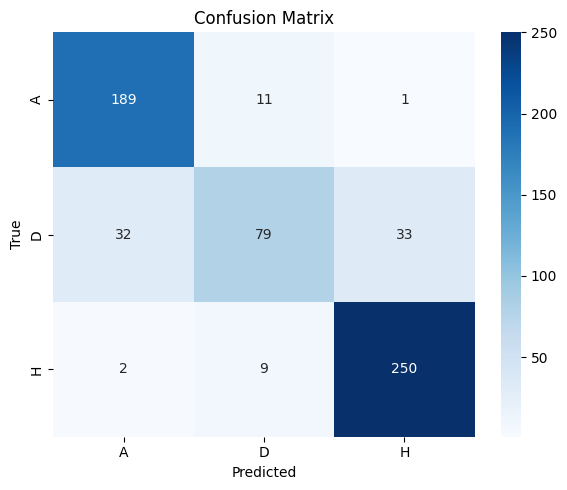

In [8]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, log_loss, balanced_accuracy_score,
    cohen_kappa_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 데이터 로딩 및 통합
input_dir = '../../data/datas/2/final'  # 경로 수정
csv_files = sorted([f for f in os.listdir(input_dir)
                    if f.startswith("final_") and f.endswith(".csv")])
df = pd.concat([pd.read_csv(os.path.join(input_dir, fn))
                for fn in csv_files],
               ignore_index=True)

# 2) 전처리: 날짜 정렬 + 수치형 피처 + 팀 더미
df['date'] = pd.to_datetime(df['date_GMT'], errors='coerce')
df.sort_values('date', inplace=True)
drop_meta = [
    'date_GMT','date','season','home_result','away_result',
    'home_gk_save_pct','away_gk_save_pct',
    'home_team_goal_count','away_team_goal_count'
]
X_num = (df.drop(columns=drop_meta, errors='ignore')
           .select_dtypes(include='number')
           .fillna(0))
team_dums = pd.get_dummies(
    df[['home_team_name','away_team_name']],
    prefix=['home','away']
)
X = pd.concat([X_num, team_dums], axis=1)

# 3) 승무패(raw) 레이블 생성 및 인코딩
y_raw = df.apply(
    lambda r: 'H' if r['home_team_goal_count'] > r['away_team_goal_count']
    else ('D' if r['home_team_goal_count'] == r['away_team_goal_count'] else 'A'),
    axis=1
)
le = LabelEncoder()
y = le.fit_transform(y_raw)  # H→0, D→1, A→2

# 4) 학습/검증/테스트 분할 (60% / 20% / 20%)
n = len(X)
i1, i2 = int(n*0.6), int(n*0.8)
X_tr, X_val, X_te = X.iloc[:i1], X.iloc[i1:i2], X.iloc[i2:]
y_tr, y_val, y_te   = y[:i1],     y[i1:i2],   y[i2:]
df_te = df.iloc[i2:].reset_index(drop=True)         # 테스트 구간 원본

# 5) XGBClassifier 정의 및 학습
model = XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, gamma=1,
    reg_alpha=1, reg_lambda=1,
    use_label_encoder=False, eval_metric='mlogloss',
    random_state=42, verbosity=0
)
model.fit(X_tr, y_tr)

# 6) 테스트셋 예측
proba = model.predict_proba(X_te)  # (n_samples, 3)
pred  = model.predict(X_te)        # 0,1,2

# 7) 경기별 결과 DataFrame 생성
results = pd.DataFrame({
    'date_GMT':    df_te['date_GMT'],
    'home_team':   df_te['home_team_name'],
    'away_team':   df_te['away_team_name'],
    'home_goals':  df_te['home_team_goal_count'],
    'away_goals':  df_te['away_team_goal_count'],
    'actual':      y_raw[i2:].values,
    'pred_label':  le.inverse_transform(pred),
    'prob_H':      proba[:, le.transform(['H'])[0]],
    'prob_D':      proba[:, le.transform(['D'])[0]],
    'prob_A':      proba[:, le.transform(['A'])[0]],
})

# 8) CSV로 저장
results.to_csv('../../output/matchResult.csv', index=False)
print("▶ 'predictions.csv' 파일로 저장했습니다:", results.shape)

# (선택) 9) Confusion Matrix 시각화
cm = confusion_matrix(y_te, pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [18]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# 1) 전체 데이터 로딩 & 병합
input_dir = '../../data/datas/2/final'  # 경로 수정
csv_files = sorted(f for f in os.listdir(input_dir)
                   if f.startswith("final_") and f.endswith(".csv"))
df_list = []
for fn in csv_files:
    tmp = pd.read_csv(os.path.join(input_dir, fn))
    tmp['season'] = fn.replace('final_','').replace('.csv','')
    df_list.append(tmp)
df = pd.concat(df_list, ignore_index=True)

# 2) 전처리 & 피처 엔지니어링
df['date_GMT'] = pd.to_datetime(df['date_GMT'], errors='coerce')
df.sort_values('date_GMT', inplace=True)
drop_meta = [
    'date_GMT','date','season',
    'home_result','away_result',
    'home_gk_save_pct','away_gk_save_pct',
    'home_team_goal_count','away_team_goal_count'
]
X_num = (df
         .drop(columns=drop_meta, errors='ignore')
         .select_dtypes(include='number')
         .fillna(0))
team_dums = pd.get_dummies(
    df[['home_team_name','away_team_name']],
    prefix=['home','away']
)
X = pd.concat([X_num, team_dums], axis=1)

# 3) 레이블 생성 & 인코딩 (H/D/A → 0/1/2)
y_raw = df.apply(lambda r:
    'H' if r.home_team_goal_count > r.away_team_goal_count
    else ('D' if r.home_team_goal_count == r.away_team_goal_count else 'A'),
    axis=1
)
le = LabelEncoder()
y = le.fit_transform(y_raw)

# 4) 학습/검증/테스트 분할 (60/20/20)
n = len(X)
i1, i2 = int(n*0.6), int(n*0.8)
X_tr, X_val, X_te = X.iloc[:i1], X.iloc[i1:i2], X.iloc[i2:]
y_tr, y_val, y_te   = y[:i1],     y[i1:i2],   y[i2:]
df_te = df.iloc[i2:].copy()        # 테스트 구간 원본 메타정보

# 5) 모델 학습
model = XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, gamma=1,
    reg_alpha=1, reg_lambda=1,
    use_label_encoder=False, eval_metric='mlogloss',
    random_state=42, verbosity=0
)
model.fit(X_tr, y_tr)

# 6) 테스트셋 전체 예측 결과(DataFrame) 생성
proba_te = model.predict_proba(X_te)
pred_te  = model.predict(X_te)
results_te = df_te[[
    'season','date_GMT','home_team_name','away_team_name',
    'home_team_goal_count','away_team_goal_count'
]].copy()
results_te['actual']     = y_raw[i2:].values
results_te['pred_label'] = le.inverse_transform(pred_te)
results_te['prob_H']     = proba_te[:, le.transform(['H'])[0]]
results_te['prob_D']     = proba_te[:, le.transform(['D'])[0]]
results_te['prob_A']     = proba_te[:, le.transform(['A'])[0]]

# 7) 전체 df에서 “직전 2개 로우” 정보로 필터링
date1 = '2023-12-06 07:30:00 PM'
date2 = '2023-12-06 07:30:00 PM'
# 문자열 비교를 위해 포맷 통일
df['date_str'] = df['date_GMT'].dt.strftime('%Y-%m-%d %I:%M:%S %p')

mask1 = (
    (df['home_team_name']=='Brighton & Hove Albion') &
    (df['away_team_name']=='Brentford') &
    (df['date_str']==date1)
)
mask2 = (
    (df['home_team_name']=='Fulham') &
    (df['away_team_name']=='Nottingham Forest') &
    (df['date_str']==date2)
)
df_up = df[mask1 | mask2].copy()

# 8) 이 두 경기만을 위한 피처 재생성
X_up_num  = df_up.drop(columns=drop_meta+['date_str'], errors='ignore') \
                 .select_dtypes(include='number') \
                 .fillna(0)
team_dums_up = pd.get_dummies(
    df_up[['home_team_name','away_team_name']],
    prefix=['home','away']
)
X_up = pd.concat([X_up_num, team_dums_up], axis=1)
X_up = X_up.reindex(columns=X.columns, fill_value=0)

# 9) “직전 2개” 예측
proba_up = model.predict_proba(X_up)
pred_up  = model.predict(X_up)
results_up = df_up[[
    'season','date_GMT','home_team_name','away_team_name',
    'home_team_goal_count','away_team_goal_count'
]].copy()
results_up['actual']     = df_up.apply(lambda r:
    'H' if r.home_team_goal_count > r.away_team_goal_count
    else ('D' if r.home_team_goal_count == r.away_team_goal_count else 'A'),
    axis=1
)
results_up['pred_label'] = le.inverse_transform(pred_up)
results_up['prob_H']     = proba_up[:, le.transform(['H'])[0]]
results_up['prob_D']     = proba_up[:, le.transform(['D'])[0]]
results_up['prob_A']     = proba_up[:, le.transform(['A'])[0]]

# 10) 두 결과를 합쳐 CSV로 저장
final_results = pd.concat([results_te, results_up], ignore_index=True)
os.makedirs('../../output', exist_ok=True)
final_results.to_csv('../../output/matchResult.csv', index=False)
print("▶ '../../output/matchResult.csv'에 전체 예측 결과 저장 완료:", final_results.shape)

# 10) 두 결과를 합친 뒤, 추가 2경기(rows_up)를 맨 앞으로 이동
final_results = pd.concat([results_te, results_up], ignore_index=True)

# 추가 2경기 개수만큼 잘라내서 맨 앞으로 붙이기
n_up = len(results_up)  # 보통 2
special = final_results.tail(n_up)
others  = final_results.iloc[:-n_up]
final_results = pd.concat([special, others], ignore_index=True)

# 11) CSV로 저장
os.makedirs('../../output', exist_ok=True)
final_results.to_csv('../../output/matchResult.csv', index=False)
print("▶ '../../output/matchResult.csv'에 전체 예측 결과 저장 완료:", final_results.shape)



▶ '../../output/matchResult.csv'에 전체 예측 결과 저장 완료: (608, 11)
▶ '../../output/matchResult.csv'에 전체 예측 결과 저장 완료: (608, 11)


▶ Test Set Classification Report:
              precision    recall  f1-score   support

           A       0.85      0.94      0.89       201
           D       0.80      0.55      0.65       144
           H       0.88      0.96      0.92       261

    accuracy                           0.85       606
   macro avg       0.84      0.82      0.82       606
weighted avg       0.85      0.85      0.85       606


▶ Additional 2 Matches Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         0
           D       0.00      0.00      0.00         0
           H       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       0.33      0.33      0.33         2
weighted avg       1.00      1.00      1.00         2



C:\Users\user080524\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user080524\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user080524\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

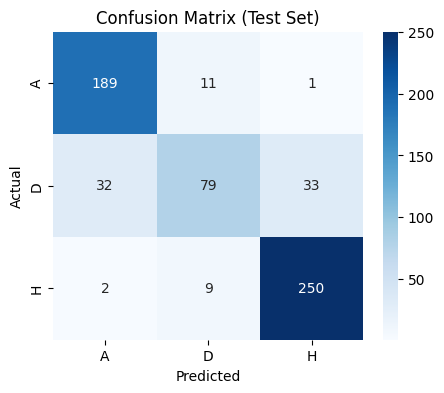

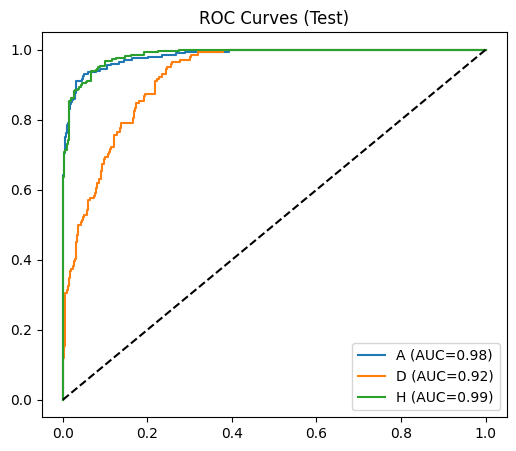

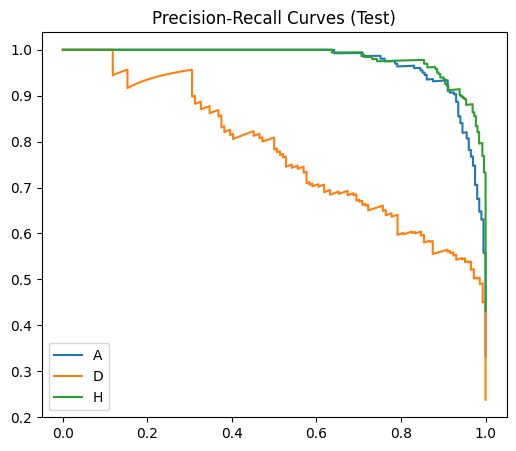

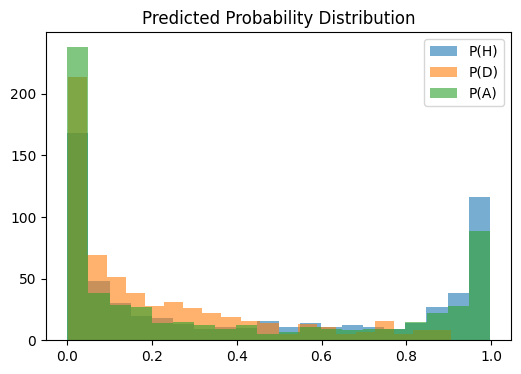

▶ '../../output/matchResult.csv' 저장 완료: (608, 11)


In [34]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# ───────── 1) 데이터 로딩 & 통합 ─────────────────────────────
input_dir = '../../data/datas/2/final'
csv_files = sorted(f for f in os.listdir(input_dir)
                   if f.startswith("final_") and f.endswith(".csv"))
df = pd.concat([
    pd.read_csv(os.path.join(input_dir, fn)).assign(season=fn.replace('final_','').replace('.csv',''))
    for fn in csv_files
], ignore_index=True)

# ───────── 2) 피처 전처리 ────────────────────────────────────
df['date_GMT'] = pd.to_datetime(df['date_GMT'], errors='coerce')
df.sort_values('date_GMT', inplace=True)
drop_meta = ['date_GMT','date','season','home_result','away_result',
             'home_gk_save_pct','away_gk_save_pct',
             'home_team_goal_count','away_team_goal_count']
X_num  = (df.drop(columns=drop_meta, errors='ignore')
            .select_dtypes(include='number')
            .fillna(0))
dummies = pd.get_dummies(df[['home_team_name','away_team_name']],
                         prefix=['home','away'])
X = pd.concat([X_num, dummies], axis=1)

# ───────── 3) 레이블 생성 & 인코딩 ───────────────────────────
y_raw = df.apply(lambda r:
    'H' if r.home_team_goal_count > r.away_team_goal_count else
    ('D' if r.home_team_goal_count == r.away_team_goal_count else 'A'),
    axis=1
)
le = LabelEncoder()
y = le.fit_transform(y_raw)

# ───────── 4) 분할 (60/20/20) ───────────────────────────────
n  = len(X)
i1, i2 = int(n*0.6), int(n*0.8)
X_tr, X_val, X_te = X.iloc[:i1], X.iloc[i1:i2], X.iloc[i2:]
y_tr, y_val, y_te = y[:i1], y[i1:i2], y[i2:]
df_te = df.iloc[i2:].copy()

# ───────── 5) 모델 학습 ────────────────────────────────────
model = XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, gamma=1,
    reg_alpha=1, reg_lambda=1,
    use_label_encoder=False, eval_metric='mlogloss',
    random_state=42, verbosity=0
)
model.fit(X_tr, y_tr)

# ───────── 6) 테스트셋 예측 ─────────────────────────────────
proba_te = model.predict_proba(X_te)
pred_te  = model.predict(X_te)
results_te = df_te[[
    'season','date_GMT','home_team_name','away_team_name',
    'home_team_goal_count','away_team_goal_count'
]].copy()
results_te['actual']      = y_raw[i2:].values
results_te['pred_label']  = le.inverse_transform(pred_te)
results_te['prob_H']      = proba_te[:, le.transform(['H'])[0]]
results_te['prob_D']      = proba_te[:, le.transform(['D'])[0]]
results_te['prob_A']      = proba_te[:, le.transform(['A'])[0]]

# ───────── 7) 추가 2경기 필터링 & 예측 ────────────────────────
df['date_str'] = df['date_GMT'].dt.strftime('%Y-%m-%d %I:%M:%S %p')
mask1 = (df.home_team_name=='Brighton & Hove Albion') & \
        (df.away_team_name=='Brentford') & \
        (df.date_str=='2023-12-06 07:30:00 PM')
mask2 = (df.home_team_name=='Fulham') & \
        (df.away_team_name=='Nottingham Forest') & \
        (df.date_str=='2023-12-06 07:30:00 PM')
df_up = df[mask1|mask2].copy()

X_up = pd.concat([
    df_up.drop(columns=drop_meta+['date_str'], errors='ignore')
         .select_dtypes(include='number').fillna(0),
    pd.get_dummies(df_up[['home_team_name','away_team_name']],
                   prefix=['home','away'])
], axis=1).reindex(columns=X.columns, fill_value=0)

proba_up = model.predict_proba(X_up)
pred_up  = model.predict(X_up)
results_up = df_up[[
    'season','date_GMT','home_team_name','away_team_name',
    'home_team_goal_count','away_team_goal_count'
]].copy()
results_up['actual']     = df_up.apply(lambda r:
    'H' if r.home_team_goal_count > r.away_team_goal_count else
    ('D' if r.home_team_goal_count == r.away_team_goal_count else 'A'),
    axis=1)
results_up['pred_label']  = le.inverse_transform(pred_up)
results_up['prob_H']      = proba_up[:, le.transform(['H'])[0]]
results_up['prob_D']      = proba_up[:, le.transform(['D'])[0]]
results_up['prob_A']      = proba_up[:, le.transform(['A'])[0]]

# ───────── 8) 분류 리포트 & 혼동행렬 ─────────────────────────
print("▶ Test Set Classification Report:")
print(classification_report(
    results_te['actual'], results_te['pred_label'],
    labels=le.classes_, target_names=le.classes_
))

print("\n▶ Additional 2 Matches Classification Report:")
print(classification_report(
    results_up['actual'], results_up['pred_label'],
    labels=le.classes_, target_names=le.classes_
))

# Confusion Matrix (Test)
cm = confusion_matrix(results_te['actual'], results_te['pred_label'], labels=le.classes_)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ───────── 9) ROC & PR Curves (Test) ─────────────────────────
y_bin = label_binarize(results_te['actual'], classes=le.classes_)
plt.figure(figsize=(6,5))
for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_bin[:,i], proba_te[:,i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (Test)"); plt.legend(); plt.show()

plt.figure(figsize=(6,5))
for i, cls in enumerate(le.classes_):
    prec, rec, _ = precision_recall_curve(y_bin[:,i], proba_te[:,i])
    plt.plot(rec, prec, label=cls)
plt.title("Precision-Recall Curves (Test)"); plt.legend(); plt.show()

# ───────── 10) 확률 분포 히스토그램 ──────────────────────────
plt.figure(figsize=(6,4))
plt.hist(proba_te[:, le.transform(['H'])[0]], bins=20, alpha=0.6, label='P(H)')
plt.hist(proba_te[:, le.transform(['D'])[0]], bins=20, alpha=0.6, label='P(D)')
plt.hist(proba_te[:, le.transform(['A'])[0]], bins=20, alpha=0.6, label='P(A)')
plt.title("Predicted Probability Distribution"); plt.legend(); plt.show()

# ───────── 11) CSV 저장 (추가 2경기 맨 앞으로) ───────────────
final_results = pd.concat([results_up, results_te], ignore_index=True)
os.makedirs('../../output', exist_ok=True)
final_results.to_csv('../../output/matchResult.csv', index=False)
print(f"▶ '../../output/matchResult.csv' 저장 완료: {final_results.shape}")


결과 비교 코드

In [29]:
import os
import pandas as pd

# 1) 파일 불러오기
df_cls = pd.read_csv('../../output/1.csv')                  # 분류 모델 결과
df_poi = pd.read_csv('../../output/predicted_score.csv')    # Poisson 예측 결과

# 2) df_poi 컬럼명 통일
df_poi = df_poi.rename(columns={
    'Date':                'date_GMT',
    'Home Team':           'home_team_name',
    'Away Team':           'away_team_name',
    'Home Win Probability':'Home Win Probability',
    'Draw Probability':    'Draw Probability',
    'Away Win Probability':'Away Win Probability'
})

# 3) 날짜 형식 통일 (날짜 부분만 비교)
df_cls['date'] = pd.to_datetime(df_cls['date_GMT']).dt.date
df_poi['date'] = pd.to_datetime(df_poi['date_GMT']).dt.date

# 4) Poisson 승무패(pred_poi) 레이블 생성
df_poi['pred_poi'] = (
    df_poi[['Home Win Probability','Draw Probability','Away Win Probability']]
    .idxmax(axis=1)
    .map({
        'Home Win Probability':'H',
        'Draw Probability':'D',
        'Away Win Probability':'A'
    })
)

# 5) 키를 기준으로 병합
keys = ['date','home_team_name','away_team_name']
df = pd.merge(
    df_cls,
    df_poi[keys + ['pred_poi']],
    on=keys,
    how='inner'
)

# 6) 분류 모델(pred_label) vs Poisson(pred_poi) 일치 여부
df['match'] = df['pred_label'] == df['pred_poi']

# 7) 결과 집계
counts = df['match'].value_counts()
print(f"▶ 일치:   {counts.get(True,0)}건")
print(f"▶ 불일치: {counts.get(False,0)}건\n")

# 8) 불일치 샘플 보기
print("▶ 불일치 샘플:")
print(df.loc[~df['match'], keys + ['pred_label','pred_poi']].head(10))

# 9) 불일치만 CSV로 저장
os.makedirs('../../output', exist_ok=True)
df.loc[~df['match']].to_csv('../../output/mismatches.csv', index=False)
print("\n▶ '../../output/mismatches.csv'에 불일치 항목 저장 완료")


▶ 일치:   376건
▶ 불일치: 134건

▶ 불일치 샘플:
          date     home_team_name          away_team_name pred_label pred_poi
5   2023-12-06  Manchester United                 Chelsea          D        H
8   2023-12-09     Crystal Palace               Liverpool          D        A
18  2023-12-16    Manchester City          Crystal Palace          D        H
21  2023-12-21     Crystal Palace  Brighton & Hove Albion          D        H
22  2023-12-22        Aston Villa        Sheffield United          D        A
28  2023-12-23          Liverpool                 Arsenal          H        A
32  2023-12-26   Sheffield United              Luton Town          H        A
47  2024-01-12            Burnley              Luton Town          H        A
48  2024-01-13            Chelsea                  Fulham          D        H
54  2024-01-21   Sheffield United         West Ham United          A        H

▶ '../../output/mismatches.csv'에 불일치 항목 저장 완료


C:\Users\user080524\AppData\Local\Temp\ipykernel_11184\1676095040.py:25: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmax(axis=1)


model pkl로 저장

In [4]:
import joblib

model_save_dir = '../service'
os.makedirs(model_save_dir, exist_ok=True)

#모델 저장
home_model_path = os.path.join(model_save_dir, 'xgb_model_home.pkl')
away_model_path = os.path.join(model_save_dir, 'xgb_model_away.pkl')
feature_columns_path = os.path.join(model_save_dir, 'trained_feature_columns.pkl')


joblib.dump(model_home, home_model_path)
joblib.dump(model_away, away_model_path)
joblib.dump(X.columns.to_list(), feature_columns_path)

print(f"✅ 모델 및 feature 저장 완료:\n"
      f"🏠 Home → {home_model_path}\n"
      f"🚌 Away → {away_model_path}\n"
      f"📑 Feature Columns → {feature_columns_path}")

✅ 모델 및 feature 저장 완료:
🏠 Home → ../service\xgb_model_home.pkl
🚌 Away → ../service\xgb_model_away.pkl
📑 Feature Columns → ../service\trained_feature_columns.pkl


prediceted_score 저장

In [21]:
from tqdm import tqdm
import pandas as pd

df = df.reset_index(drop=True)
test_indices = X_test.index
test_df = df.loc[test_indices].reset_index(drop=True)

detailed_results = []

def clean_score_value(val):
    """
    '05' -> '5', '5+' -> '5+', '00' -> '0', None -> ''
    """
    if val is None:
        return ""
    val_str = str(val).strip()
    return val_str.lstrip("0") if val_str != "0" and val_str != "5+" else val_str

for i in tqdm(range(len(X_test))):
    x = X_test.iloc[[i]]
    pred = predict_scores_with_prob(x, top_k=3)
    top_preds = pred["top_predictions"]

    row_result = {
        "Date": test_df.iloc[i]["date"].strftime("%Y-%m-%d") if pd.notnull(test_df.iloc[i]["date"]) else "NaT",
        "Home Team": test_df.iloc[i]["home_team_name"],
        "Away Team": test_df.iloc[i]["away_team_name"],
        "Expected Home Goals": round(pred["home_expected_goals"], 3),
        "Expected Away Goals": round(pred["away_expected_goals"], 3),
        "Home Win Probability": round(pred["home_win_prob"], 4),
        "Draw Probability": round(pred["draw_prob"], 4),
        "Away Win Probability": round(pred["away_win_prob"], 4)
    }

    for rank, ((h, a), prob) in enumerate(top_preds, 1):
        h_clean = clean_score_value(h)
        a_clean = clean_score_value(a)

        score_str = f"{h_clean}-{a_clean}" if h_clean != "" and a_clean != "" else ""
        row_result[f"Top-{rank}"] = f"'{score_str}'"  # 문자열로 강제 저장
        row_result[f"Top-{rank} Prob"] = round(prob, 4) if pd.notnull(prob) else None

    detailed_results.append(row_result)

df_detailed = pd.DataFrame(detailed_results)
output_path = "../../output/predicted_score.csv"
df_detailed.to_csv(output_path, index=False)
print(f"✅ CSV 저장 완료: {output_path}")


100%|██████████| 510/510 [00:14<00:00, 35.38it/s]

✅ CSV 저장 완료: ../../output/predicted_score.csv


In [3]:
import pymysql
from tqdm import tqdm
import pandas as pd

# 1. DB 연결
conn = pymysql.connect(
    host="premo-instance.czwmu86ms4yl.us-east-1.rds.amazonaws.com",
    user="admin",
    password="tteam891",
    db="premo",
    charset="utf8mb4",
    cursorclass=pymysql.cursors.DictCursor
)

# 2. 팀 이름 매핑 (CSV → DB)
team_folder_map = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton & Hove Albion" : "Brighton"
}

# 3. team_name → team_id 매핑 (common_name + short_name, 소문자)
with conn.cursor() as cursor:
    cursor.execute("SELECT team_id, team_common_name, short_name FROM team")
    team_rows = cursor.fetchall()

team_name_to_id = {}
for row in team_rows:
    team_name_to_id[row['team_common_name'].lower()] = row['team_id']
    team_name_to_id[row['short_name'].lower()] = row['team_id']

# 4. CSV 로딩
df = pd.read_csv("../../output/predicted_score.csv")

# 5. INSERT SQL
insert_sql = """
INSERT INTO model_output (
    match_id,
    home_winrate, drawrate, away_winrate,
    home_score_1, away_score_1, score_1_prob,
    home_score_2, away_score_2, score_2_prob,
    home_score_3, away_score_3, score_3_prob,
    prediction_date, created_at, updated_at
) VALUES (
    %(match_id)s,
    %(home_winrate)s, %(drawrate)s, %(away_winrate)s,
    %(home_score_1)s, %(away_score_1)s, %(score_1_prob)s,
    %(home_score_2)s, %(away_score_2)s, %(score_2_prob)s,
    %(home_score_3)s, %(away_score_3)s, %(score_3_prob)s,
    NOW(), NOW(), NOW()
);
"""

# 6. INSERT 반복
with conn.cursor() as cursor:
    for i in tqdm(range(len(df))):
        row = df.iloc[i]

        # 결측값 존재 시 스킵
        if pd.isna(row["Home Win Probability"]) or pd.isna(row["Draw Probability"]) or pd.isna(row["Away Win Probability"]):
            print(f"⚠️ 확률 결측 → 건너뜀: {row.get('Home Team')} vs {row.get('Away Team')} on {row.get('Date')}")
            continue

        # 팀 이름 매핑 적용
        home_team_name = team_folder_map.get(row["Home Team"], row["Home Team"]).lower()
        away_team_name = team_folder_map.get(row["Away Team"], row["Away Team"]).lower()

        home_team_id = team_name_to_id.get(home_team_name)
        away_team_id = team_name_to_id.get(away_team_name)
        row_date = pd.to_datetime(row["Date"]).strftime("%Y-%m-%d")

        if home_team_id is None or away_team_id is None:
            print(f"❌ 팀 ID 매핑 실패: {row['Home Team']} / {row['Away Team']}")
            continue

        # match_id 찾기
        cursor.execute("""
            SELECT match_id FROM `match`
            WHERE home_team_id = %s AND away_team_id = %s AND start_time = %s
        """, (home_team_id, away_team_id, row_date))
        result = cursor.fetchone()

        if not result:
            print(f"❌ Match not found: {row['Home Team']} vs {row['Away Team']} on {row['Date']}")
            continue

        match_id = result["match_id"]

        # INSERT 데이터 구성
        insert_data = {
            "match_id": match_id,
            "home_winrate": round(float(row["Home Win Probability"]) * 100, 2),
            "drawrate": round(float(row["Draw Probability"]) * 100, 2),
            "away_winrate": round(float(row["Away Win Probability"]) * 100, 2),
        }

        for k in range(1, 4):
            score = str(row.get(f"Top-{k}", "")).replace("'", "").strip()
            prob = row.get(f"Top-{k} Prob", 0)

            if "-" in score:
                h, a = score.split("-", 1)
                h = h.strip()
                a = a.strip()
            else:
                h, a = None, None

            insert_data[f"home_score_{k}"] = h if h else None
            insert_data[f"away_score_{k}"] = a if a else None
            insert_data[f"score_{k}_prob"] = float(prob) * 100 if pd.notnull(prob) else None
            
        cursor.execute(insert_sql, insert_data)

    conn.commit()

print("✅ model_output 테이블에 INSERT 완료")


 46%|████▋     | 237/510 [01:25<01:38,  2.79it/s]

⚠️ 확률 결측 → 건너뜀: West Ham United vs Chelsea on 2024-09-21


 58%|█████▊    | 297/510 [01:46<01:16,  2.78it/s]

⚠️ 확률 결측 → 건너뜀: Arsenal vs Nottingham Forest on 2024-11-23


 90%|█████████ | 461/510 [02:44<00:17,  2.80it/s]

⚠️ 확률 결측 → 건너뜀: Nottingham Forest vs Everton on 2025-04-12


100%|██████████| 510/510 [03:01<00:00,  2.81it/s]

✅ model_output 테이블에 INSERT 완료


In [30]:
import pymysql
from tqdm import tqdm
import pandas as pd

# 1. DB 연결
conn = pymysql.connect(
    host="premo-instance.czwmu86ms4yl.us-east-1.rds.amazonaws.com",
    user="admin",
    password="tteam891",
    db="premo",
    charset="utf8mb4",
    cursorclass=pymysql.cursors.DictCursor
)

# 2. 팀 이름 매핑 (CSV → DB)
team_folder_map = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton & Hove Albion" : "Brighton"
}

# 3. team_name → team_id 매핑 (common_name + short_name, 소문자)
with conn.cursor() as cursor:
    cursor.execute("SELECT team_id, team_common_name, short_name FROM team")
    team_rows = cursor.fetchall()

team_name_to_id = {}
for row in team_rows:
    team_name_to_id[row['team_common_name'].lower()] = row['team_id']
    team_name_to_id[row['short_name'].lower()] = row['team_id']

# 4. CSV 로딩
df = pd.read_csv("../../output/matchResult.csv")

# 5) UPDATE 문 준비
update_sql = """
UPDATE model_output
SET predictedResult = %s,
    updated_at = NOW()
WHERE match_id = %s
"""

# 6) 한 건씩 루프 돌며 match_id 찾고 UPDATE
with conn.cursor() as cur:
    for _, r in tqdm(df.iterrows(), total=len(df)):
        # 6.1) 팀명 표준화 → 소문자
        home = team_folder_map.get(r['home_team_name'], r['home_team_name']).lower()
        away = team_folder_map.get(r['away_team_name'], r['away_team_name']).lower()

        # 6.2) team_id 조회
        hid = team_name_to_id.get(home)
        aid = team_name_to_id.get(away)
        if hid is None or aid is None:
            print(f"⚠️ 팀ID 없음: {r['home_team_name']}, {r['away_team_name']}")
            continue

        # 6.3) 날짜 포맷 맞추기 (YYYY-MM-DD)
        match_date = pd.to_datetime(r['date_GMT']).strftime('%Y-%m-%d')

        # 6.4) match_id 조회
        cur.execute("""
            SELECT match_id
              FROM `match`
             WHERE home_team_id=%s
               AND away_team_id=%s
               AND DATE(start_time)= %s
        """, (hid, aid, match_date))
        m = cur.fetchone()
        if not m:
            print(f"⚠️ Match 미발견: {r['home_team_name']} vs {r['away_team_name']} on {match_date}")
            continue

        match_id = m['match_id']
        pred     = r['pred_label']  # H, D, A

        # 6.5) model_output.predictedResult 업데이트
        cur.execute(update_sql, (pred, match_id))

    conn.commit()

conn.close()
print("✅ model_output.predictedResult 업데이트 완료")

100%|██████████| 608/608 [03:36<00:00,  2.80it/s]

✅ model_output.predictedResult 업데이트 완료
